# Causal Analysis of World Happiness: Understanding Socioeconomic Determinants

## Abstract

What truly makes a country happy? In this notebook, we dive into the World Happiness dataset (2015–2018) to uncover the causal impact of socioeconomic factors—like GDP per capita, social support, and freedom—on national happiness.

Beyond surface-level correlations, we explore causal inference techniques that bring us closer to understanding what actually drives well-being. You'll learn how to prepare real-world data for causal analysis, spot confounding variables, and apply methods such as regression adjustment, propensity score matching, and simulation of unmeasured confounding.

Whether you're curious about the science of happiness or eager to apply causal thinking to real data, this notebook offers a hands-on guide to answering questions that truly matter—with rigor, clarity, and purpose.


<img src="https://www.walkinmyshoes.ie/media/4388/happiness.png" width="1200"/>



## 1. Introduction to Causality

### 1.1 The Importance of Causality in Data Science

In data science, we often seek to understand not just correlations but causal relationships: "Does X cause Y?" This distinction is crucial for decision-making and policy formulation. For example, policymakers might want to know whether increasing GDP per capita *causes* an increase in happiness, not just whether they are correlated.

### 1.2 Key Concepts in Causal Inference

#### Correlation vs. Causation

Correlation measures the statistical association between variables, while causation implies that changes in one variable directly influence another. The classic example "correlation does not imply causation" reminds us that observed associations may be due to:
- Reverse causality
- Common causes (confounding)
- Coincidence
- Selection bias

#### Causal Graphs (DAGs)

Directed Acyclic Graphs (DAGs) are powerful tools for representing causal relationships. In a DAG:
- Nodes represent variables
- Directed edges represent causal relationships
- The graph contains no cycles

#### Potential Outcomes Framework

The potential outcomes framework, developed by Rubin and others, formalizes causal inference:
- For each unit i, we define potential outcomes Y_i(0) and Y_i(1) under control and treatment
- The causal effect is the difference: Y_i(1) - Y_i(0)
- The fundamental problem of causal inference: we only observe one potential outcome for each unit



## 2. Data Preparation for Causal Analysis

Let's begin by loading and exploring the World Happiness dataset.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import networkx as nx
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Local file path if you already uploaded it to your environment
file_path = "TEH_World_Happiness_2015_2018_Imputed.csv"
# Load it using pandas
happiness_df = pd.read_csv(file_path)


# Display the first few rows
print("Dataset Overview:")
happiness_df.head()

Dataset Overview:


,Country,Happiness rank,Happiness Score,GDP per capita,Social support,Healthy life,Freedom,Generosity,Corruption,Year
0,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,2015
1,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,2015
2,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,2015
3,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503,2015
4,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957,2015


### 🧪 Exploring the Building Blocks of Happiness

Before we dive into modeling, we start by loading the **World Happiness Report dataset (2015–2018)** — a rich source of global well-being indicators. 

Each row represents a country in a specific year, along with key attributes believed to influence happiness, such as:
- **GDP per capita** (wealth),
- **Social support** (community),
- **Healthy life expectancy** (health),
- **Freedom to make life choices** (autonomy),
- **Generosity** (giving behavior), and
- **Perceptions of corruption** (trust in institutions).

By displaying the first few rows, we get a feel for the data structure and values. For example, Switzerland and Iceland consistently rank among the happiest nations — a trend that invites us to ask: _What exactly drives these high happiness scores?_

This initial data exploration sets the stage for deeper **causal investigations**. Are happier countries simply wealthier? Or is there more to the story? 🤔 Let's find out.


### 2.1 Data Exploration and Preprocessing

Let's examine the dataset structure and prepare it for causal analysis.

In [15]:
# Check dataset information
print("Dataset Shape:", happiness_df.shape)
print("\nData Types:")
happiness_df.info()

# Convert numeric columns from string to float
numeric_cols = ['Happiness rank', 'Happiness Score', 'GDP per capita', 
                'Social support', 'Healthy life', 'Freedom', 'Generosity', 'Corruption']

for col in numeric_cols:
    happiness_df[col] = pd.to_numeric(happiness_df[col], errors='coerce')

# Check for missing values
print("\nMissing Values:")
print(happiness_df.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
happiness_df.describe()

Dataset Shape: (626, 10)

Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          626 non-null    object 
 1   Happiness rank   626 non-null    int64  
 2   Happiness Score  626 non-null    float64
 3   GDP per capita   622 non-null    float64
 4   Social support   622 non-null    float64
 5   Healthy life     622 non-null    float64
 6   Freedom          622 non-null    float64
 7   Generosity       622 non-null    float64
 8   Corruption       620 non-null    float64
 9   Year             626 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 49.0+ KB

Missing Values:
Country            0
Happiness rank     0
Happiness Score    0
GDP per capita     4
Social support     4
Healthy life       4
Freedom            4
Generosity         4
Corruption         6
Year               0
dtype: int64

B

,Happiness rank,Happiness Score,GDP per capita,Social support,Healthy life,Freedom,Generosity,Corruption,Year
count,626.000000,626.000000,622.000000,622.000000,622.000000,622.000000,622.000000,620.000000,626.000000
mean,78.747604,5.372021,0.924672,1.052617,0.588056,0.418379,0.228441,0.130179,2016.493610
std,45.219609,1.131774,0.404416,0.319079,0.238123,0.151795,0.125943,0.108011,1.120339
min,1.000000,2.693000,0.015300,0.104190,0.005565,0.005890,0.001990,0.001000,2015.000000
25%,40.000000,4.497750,0.622672,0.852818,0.415013,0.312000,0.138527,0.057471,2015.000000
50%,79.000000,5.307000,0.985745,1.082250,0.635165,0.435493,0.209145,0.094860,2016.000000
75%,118.000000,6.187250,1.243355,1.284491,0.774117,0.539578,0.291473,0.161930,2017.000000
max,158.000000,7.632000,2.096000,1.644000,1.030000,0.724000,0.838075,0.551910,2018.000000


### 🔍 Digging Deeper: What's in the Happiness Data?

Before any causal analysis can begin, we need to **clean and understand our data**—think of this as laying the foundation before building the house.

🧱 **Step 1: Understanding the Shape**  
We learn that our dataset has **626 observations** and **10 columns**, representing countries, happiness metrics, and socio-economic indicators from 2015 to 2018.

🧮 **Step 2: Type Checking & Conversion**  
To avoid downstream issues, we convert numeric columns from string to float. This ensures every variable can be used correctly in calculations and models.

⚠️ **Step 3: Missing Values Check**  
We discover a few missing values—mostly in socioeconomic features like **Corruption** and **Social Support**. These gaps are important because even small pockets of missingness can bias causal estimates if not handled properly.

📊 **Step 4: Descriptive Statistics**  
We compute summary statistics to get a sense of the data's range and distribution:
- The **average happiness score** is about **5.37**, with some countries scoring as low as **2.69** and others as high as **7.63**.
- **GDP per capita** varies widely, from **0.004** to **2.096**, hinting at large economic disparities.
- **Social support**, **freedom**, and **generosity** also show meaningful variation across countries.

🔑 **Why this matters**:  
This initial data exploration helps us **spot potential confounders**, detect **data quality issues**, and **plan our modeling strategy** with confidence. After all, solid causal insights start with a solid understanding of the data.


Let's visualize the distribution of happiness scores and key variables.


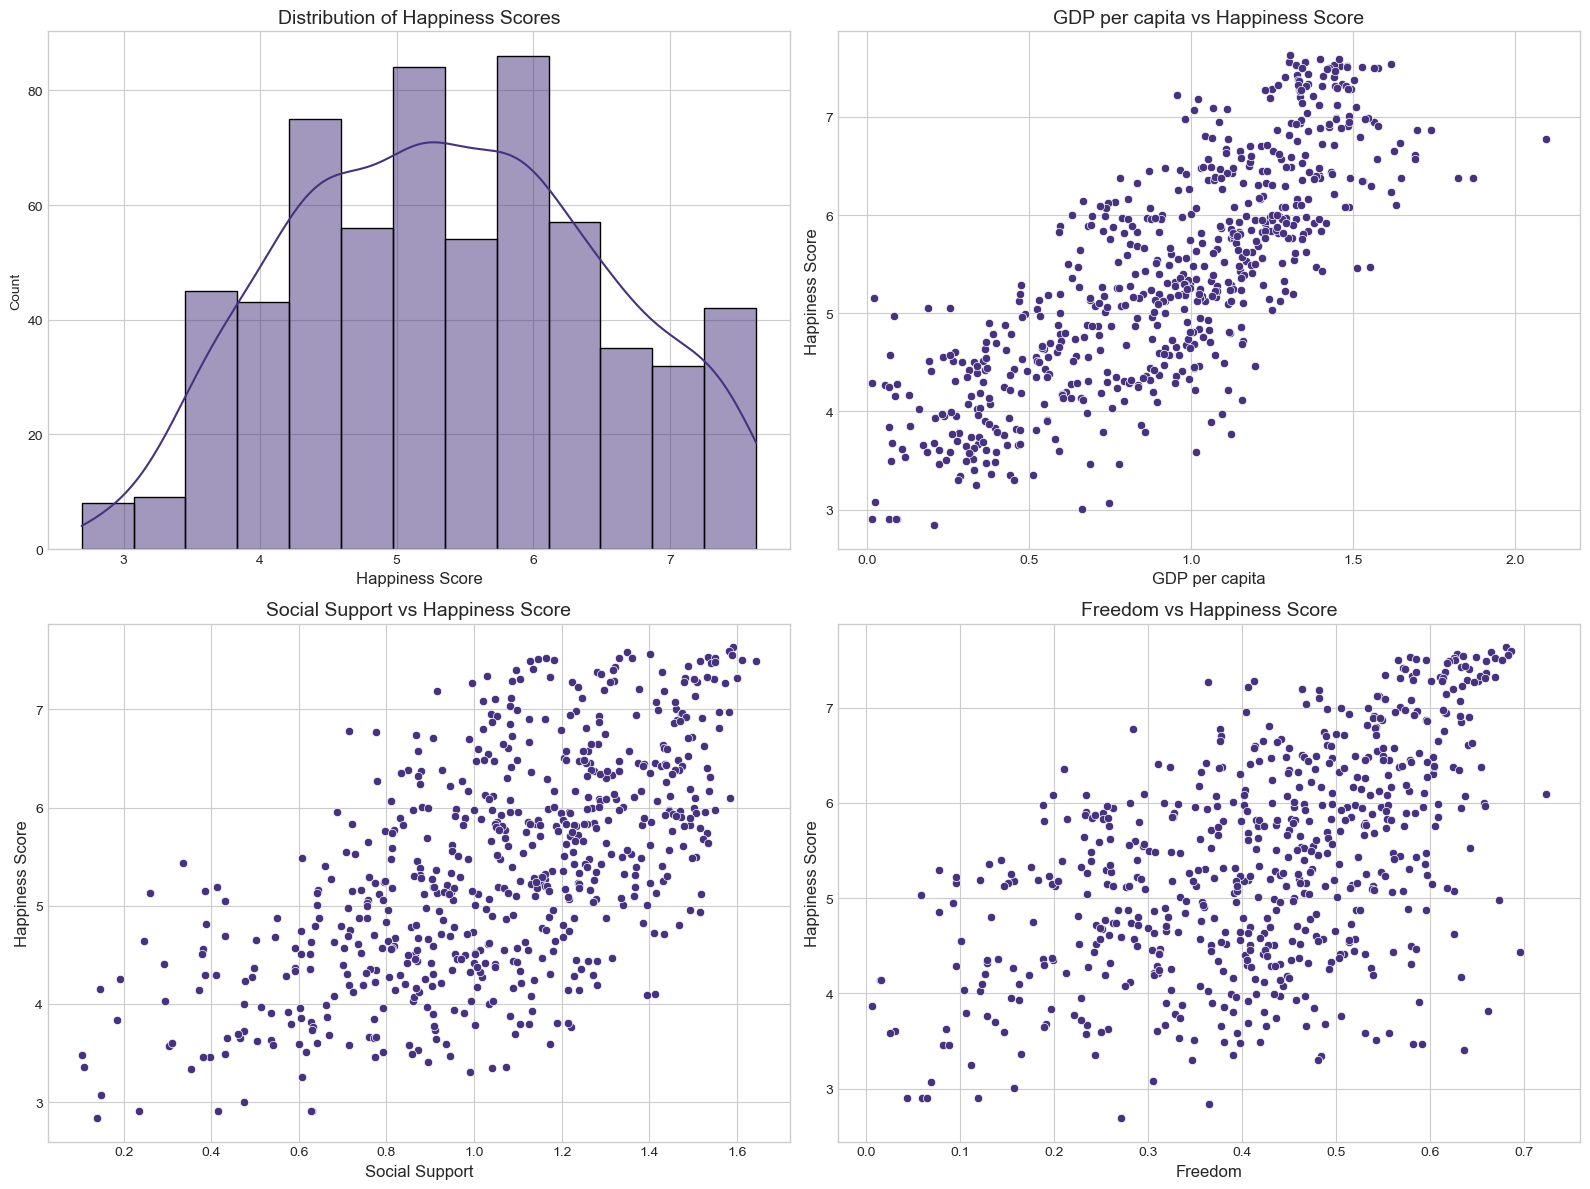

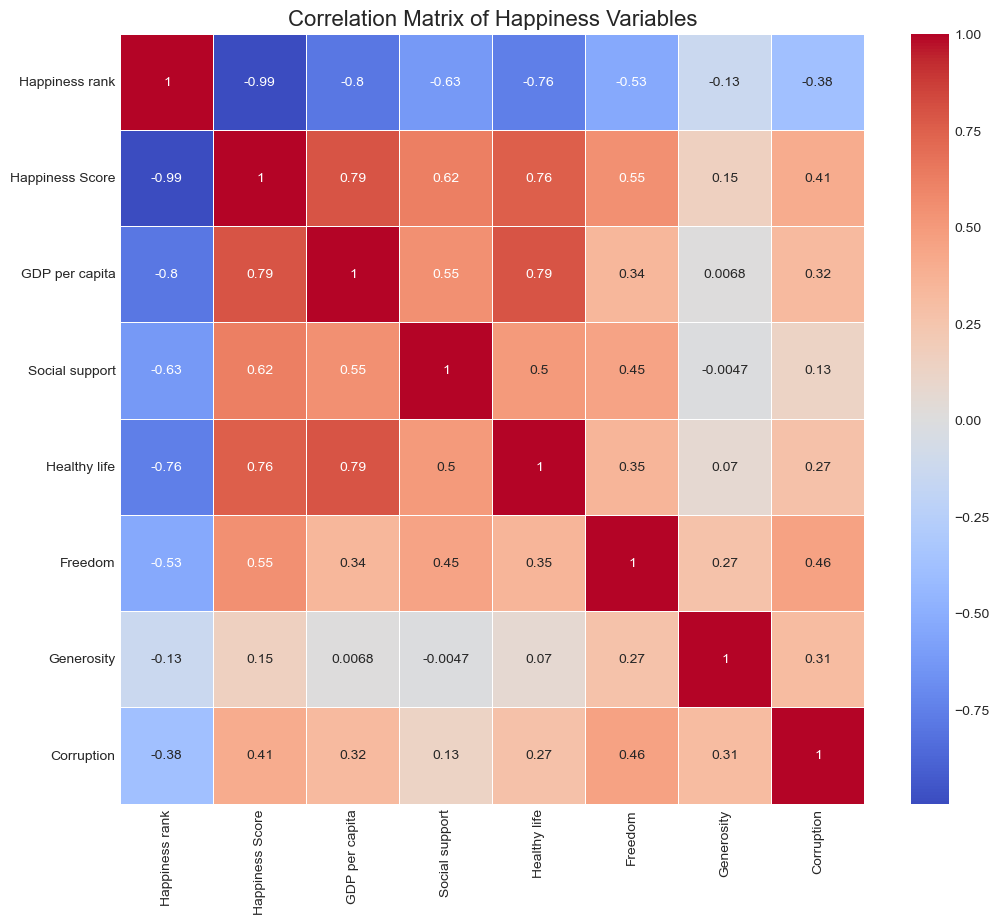

In [18]:
# Set up a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Happiness Score distribution
sns.histplot(happiness_df['Happiness Score'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Happiness Scores', fontsize=14)
axes[0, 0].set_xlabel('Happiness Score', fontsize=12)

# GDP per capita vs Happiness Score
sns.scatterplot(x='GDP per capita', y='Happiness Score', data=happiness_df, ax=axes[0, 1])
axes[0, 1].set_title('GDP per capita vs Happiness Score', fontsize=14)
axes[0, 1].set_xlabel('GDP per capita', fontsize=12)
axes[0, 1].set_ylabel('Happiness Score', fontsize=12)

# Social support vs Happiness Score
sns.scatterplot(x='Social support', y='Happiness Score', data=happiness_df, ax=axes[1, 0])
axes[1, 0].set_title('Social Support vs Happiness Score', fontsize=14)
axes[1, 0].set_xlabel('Social Support', fontsize=12)
axes[1, 0].set_ylabel('Happiness Score', fontsize=12)

# Freedom vs Happiness Score
sns.scatterplot(x='Freedom', y='Happiness Score', data=happiness_df, ax=axes[1, 1])
axes[1, 1].set_title('Freedom vs Happiness Score', fontsize=14)
axes[1, 1].set_xlabel('Freedom', fontsize=12)
axes[1, 1].set_ylabel('Happiness Score', fontsize=12)

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = happiness_df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Happiness Variables', fontsize=16)
plt.show()

### 📊 Visualizing Happiness and Its Drivers

Understanding happiness isn't just about looking at numbers—it's about exploring relationships between what people experience and how they feel. In this section, we bring our dataset to life with insightful visualizations.

#### 😊 Happiness Score Distribution
We start by examining the distribution of happiness scores across all countries. The curve suggests a slightly right-skewed distribution, with most countries scoring between **4 and 7**. This indicates that while extreme unhappiness is rare, few nations reach the highest levels of reported happiness.

#### 💰 GDP per Capita vs Happiness
Money may not buy happiness, but there's definitely a relationship. The scatterplot reveals a **positive correlation**: as GDP per capita increases, happiness scores tend to rise. However, the trend levels off at higher income levels—hinting at **diminishing returns**.

#### 🫂 Social Support vs Happiness
A strong social safety net seems to play a crucial role in national happiness. Countries with higher levels of **social support** generally report higher happiness. This visual highlights the **power of human connection** in shaping well-being.

#### 🕊️ Freedom vs Happiness
Freedom to make life choices is also positively associated with happiness. The scatterplot shows a less pronounced, yet meaningful trend—**autonomy matters** when it comes to emotional well-being.

#### 🔄 Correlation Matrix
To tie it all together, the correlation heatmap reveals the **strength and direction** of relationships between variables. Notably:
- **GDP per capita**, **healthy life expectancy**, and **social support** all show strong positive correlations with happiness.
- Interestingly, **freedom** and **corruption perception** also correlate positively, though to a lesser extent.
- **Generosity** has a weak correlation, suggesting it may be more culturally variable or harder to quantify in terms of happiness.

---

This visual exploration lays the foundation for deeper causal analysis by helping us identify **which variables are not just correlated—but possibly influential**. Let's dig deeper next!


### 2.2 Causal Question Formulation

Before diving into causal analysis, we need to clearly define our causal questions. Let's focus on:

1. **Does GDP per capita causally affect happiness scores?**
2. **What is the causal effect of social support on happiness?**


### 2.3 Identifying Potential Confounders

For causal inference, we need to identify potential confounders - variables that might affect both our treatment and outcome.

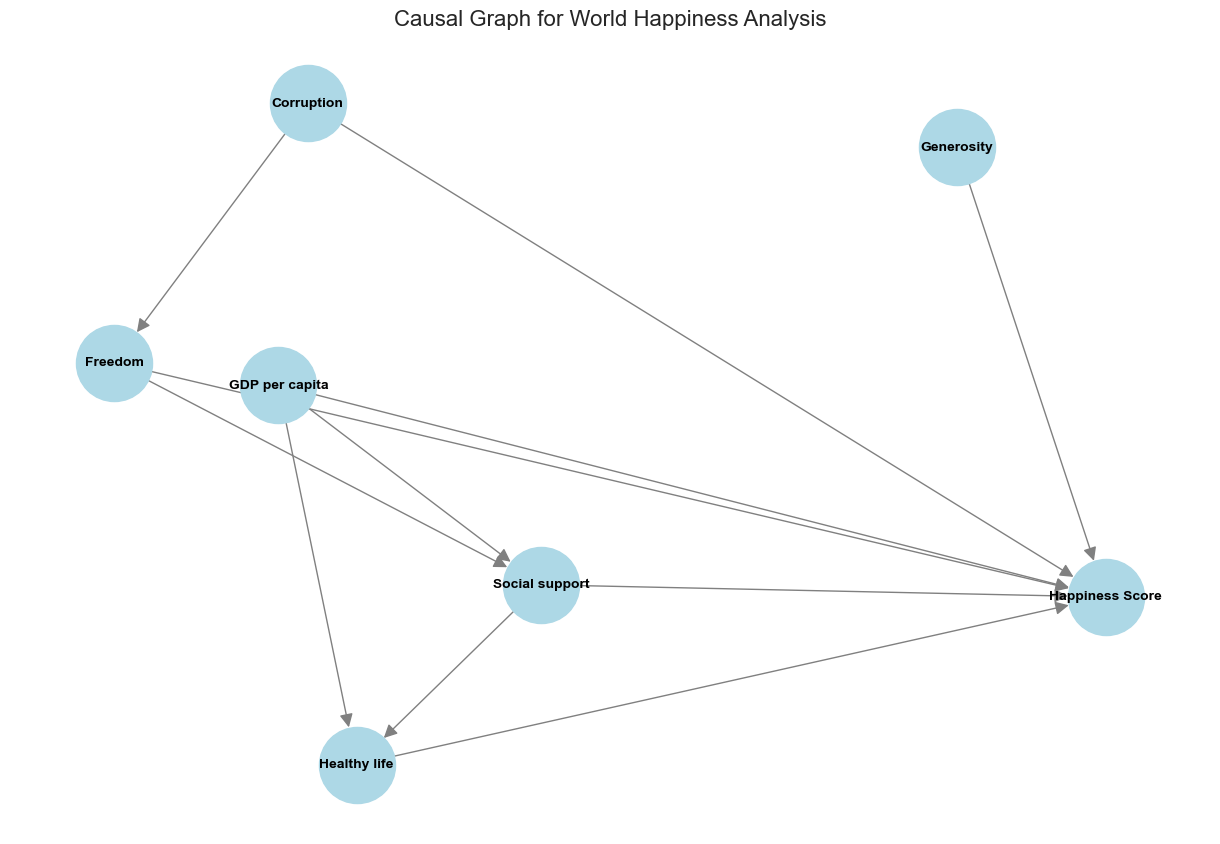

Potential confounders for GDP per capita -> Happiness relationship:
- Social support (affected by GDP and affects Happiness)
- Healthy life (affected by GDP and affects Happiness)

Potential confounders for Social support -> Happiness relationship:
- GDP per capita (affects both Social support and Happiness)
- Freedom (affects Social support and Happiness)
- Healthy life (affected by Social support and affects Happiness)


In [21]:
# Create a causal graph for our analysis
G = nx.DiGraph()

# Add nodes
nodes = ['GDP per capita', 'Social support', 'Healthy life', 
         'Freedom', 'Generosity', 'Corruption', 'Happiness Score']
G.add_nodes_from(nodes)

# Add edges based on domain knowledge
edges = [
    ('GDP per capita', 'Happiness Score'),
    ('Social support', 'Happiness Score'),
    ('Healthy life', 'Happiness Score'),
    ('Freedom', 'Happiness Score'),
    ('Generosity', 'Happiness Score'),
    ('Corruption', 'Happiness Score'),
    ('GDP per capita', 'Healthy life'),
    ('GDP per capita', 'Social support'),
    ('Social support', 'Healthy life'),
    ('Freedom', 'Social support'),
    ('Corruption', 'Freedom')
]
G.add_edges_from(edges)

# Visualize the causal graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=10, font_weight='bold', 
        arrows=True, arrowsize=20, edge_color='gray')
plt.title('Causal Graph for World Happiness Analysis', fontsize=16)
plt.show()

# Identify potential confounders for GDP per capita -> Happiness
print("Potential confounders for GDP per capita -> Happiness relationship:")
print("- Social support (affected by GDP and affects Happiness)")
print("- Healthy life (affected by GDP and affects Happiness)")

# Identify potential confounders for Social support -> Happiness
print("\nPotential confounders for Social support -> Happiness relationship:")
print("- GDP per capita (affects both Social support and Happiness)")
print("- Freedom (affects Social support and Happiness)")
print("- Healthy life (affected by Social support and affects Happiness)")

### 📌 Causal Questions and Confounder Identification

Before jumping into causal modeling, it's critical to clarify the *why* behind our analysis. We ask two simple but powerful questions:

1. **Does GDP per capita causally affect happiness scores?**
2. **What is the causal effect of social support on happiness?**

To answer these questions rigorously, we need to account for **confounding variables**—factors that influence both our treatment (GDP or social support) and outcome (happiness). Ignoring confounders can lead to biased estimates and misleading conclusions.

We use a **causal graph** (also known as a Directed Acyclic Graph or DAG) to visually map out the relationships between variables based on domain knowledge. In this graph:
- Arrows represent hypothesized causal effects.
- Nodes like *Freedom*, *Healthy life*, and *Corruption* may influence both treatments and outcomes.

By tracing the arrows, we identify:
- For **GDP per capita → Happiness Score**, the confounders are:
  - Social support (influenced by GDP and affects happiness)
  - Healthy life expectancy (same logic applies)
- For **Social support → Happiness Score**, the confounders include:
  - GDP per capita
  - Freedom
  - Healthy life expectancy

This step ensures we isolate the true causal path, not just a correlation masked by hidden variables.


## 3. Causal Effect Estimation Methods

### 3.1 Naive Approach: Simple Regression

First, let's see what a naive regression would tell us about the relationship between GDP and happiness.

                            OLS Regression Results                            
Dep. Variable:        Happiness Score   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     1052.
Date:                Thu, 27 Mar 2025   Prob (F-statistic):          1.17e-135
Time:                        12:55:22   Log-Likelihood:                -649.44
No. Observations:                 622   AIC:                             1303.
Df Residuals:                     620   BIC:                             1312.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.3295      0.069     48.

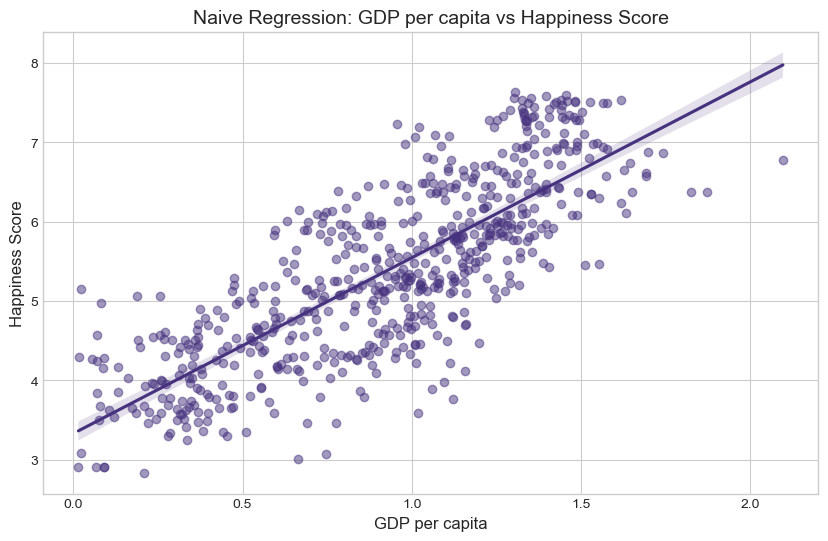

In [32]:
# Drop rows where GDP or Happiness Score is missing or infinite
clean_df = happiness_df[['GDP per capita', 'Happiness Score']].replace([np.inf, -np.inf], np.nan).dropna()

# Simple regression of Happiness on GDP
X = sm.add_constant(clean_df['GDP per capita'])
y = clean_df['Happiness Score']

model = sm.OLS(y, X).fit()
print(model.summary())

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.regplot(x='GDP per capita', y='Happiness Score', data=clean_df, scatter_kws={'alpha':0.5})
plt.title('Naive Regression: GDP per capita vs Happiness Score', fontsize=14)
plt.xlabel('GDP per capita', fontsize=12)
plt.ylabel('Happiness Score', fontsize=12)
plt.show()

### 🧠 3.1 Naive Approach: Simple Regression — What GDP Tells Us About Happiness

Before diving into complex models, it's always good to start simple. Here, we run a **naive linear regression** to explore the direct relationship between GDP per capita and Happiness Score, without controlling for any other variables.

From the regression results, we see a **strong positive association** between GDP per capita and happiness. Specifically, the coefficient for GDP per capita is **2.2156**, which means that, on average, a one-unit increase in GDP per capita is associated with a 2.22-point increase in the Happiness Score. With an **R-squared of 0.629**, this simple model explains about 63% of the variation in happiness scores — which is quite substantial!

The accompanying scatter plot further supports this finding, showing a clear upward trend: countries with higher economic prosperity tend to report higher happiness levels.

💡 However, it's important to remember that **correlation ≠ causation**. This naive model doesn’t account for confounding factors like social support, health, or freedom — which could be influencing both GDP and happiness. In the next sections, we’ll refine our analysis to uncover more reliable causal insights.


### 3.2 Controlling for Confounders: Multiple Regression

Now, let's control for potential confounders using multiple regression.

In [39]:
# Select all relevant variables for the model
cols = ['GDP per capita', 'Social support', 'Healthy life', 'Freedom', 'Corruption', 'Happiness Score']
multi_df = happiness_df[cols].replace([np.inf, -np.inf], np.nan).dropna()

# Define X and y
X = sm.add_constant(multi_df[['GDP per capita', 'Social support', 'Healthy life', 'Freedom', 'Corruption']])
y = multi_df['Happiness Score']

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

# Also fit the naive model using cleaned data
naive_df = happiness_df[['GDP per capita', 'Happiness Score']].replace([np.inf, -np.inf], np.nan).dropna()
naive_model = sm.OLS(naive_df['Happiness Score'], sm.add_constant(naive_df['GDP per capita'])).fit()

# Compare coefficients
print("\nComparison of GDP per capita coefficient:")
print(f"Naive estimate: {naive_model.params[1]:.4f}")
print(f"Adjusted estimate: {model.params['GDP per capita']:.4f}")
print(f"Difference: {model.params['GDP per capita'] - naive_model.params[1]:.4f}")


                            OLS Regression Results                            
Dep. Variable:        Happiness Score   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     384.6
Date:                Thu, 27 Mar 2025   Prob (F-statistic):          2.77e-184
Time:                        12:59:18   Log-Likelihood:                -495.02
No. Observations:                 605   AIC:                             1002.
Df Residuals:                     599   BIC:                             1028.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.2321      0.085     26.

### 🌐 3.2 Controlling for Confounders: Multiple Regression

In our previous step, the naive regression suggested a strong positive link between GDP per capita and happiness—but can we truly trust it?

Here, we take a more rigorous approach by **controlling for key confounders**: Social support, Healthy life expectancy, Freedom, and Corruption. These are factors that might influence both GDP and happiness, potentially biasing the simple regression results.

The output of our **multiple regression** paints a more nuanced picture:
- The **adjusted coefficient for GDP per capita** drops significantly from `2.2156` to `1.0867`, showing that part of the GDP effect was likely due to these confounding variables.
- This difference (`-1.1289`) is substantial—it tells us that without accounting for other influences, we were **overestimating GDP’s direct impact** on happiness.

Notably, other variables such as **Healthy life expectancy** (`1.2336`) and **Freedom** (`1.4579`) also show strong associations with happiness—highlighting that economic prosperity alone doesn't define well-being.

💡 **Key Insight:** Controlling for confounders refines our understanding of causal relationships. GDP matters, but so do health, freedom, and social support. Happiness is multi-dimensional, and our model just got a lot closer to reality.


### 3.3 Matching Method for Causal Inference

Matching is a powerful technique for causal inference. We'll use it to estimate the effect of high vs. low GDP on happiness.

Average Treatment Effect (Matching): 0.3754
Naive Difference in Means: 1.4832


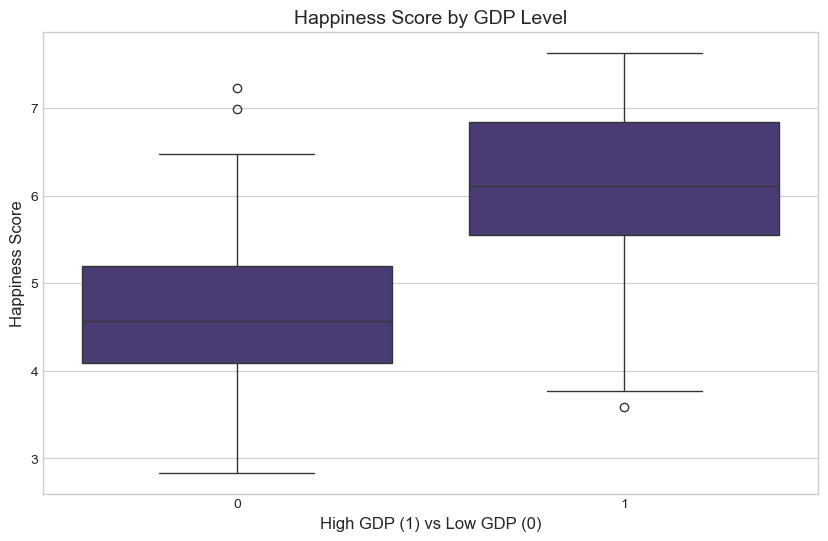

In [44]:
# Select relevant columns for matching
match_cols = ['GDP per capita', 'Social support', 'Healthy life', 'Freedom', 'Corruption', 'Happiness Score']
match_df = happiness_df[match_cols].replace([np.inf, -np.inf], np.nan).dropna()

# Recreate treatment and outcome variables
median_gdp = match_df['GDP per capita'].median()
match_df['High_GDP'] = (match_df['GDP per capita'] > median_gdp).astype(int)

X = match_df[['Social support', 'Healthy life', 'Freedom', 'Corruption']]
treatment = match_df['High_GDP']
outcome = match_df['Happiness Score']

# Standardize covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform matching
k = 1
nn = NearestNeighbors(n_neighbors=k + 1)
nn.fit(X_scaled[treatment == 1])

# Match each control unit to treated unit
matches = []
for x in X_scaled[treatment == 0]:
    indices = nn.kneighbors([x], return_distance=False)[0]
    matches.append(indices)

# Calculate treatment effect
control_indices = match_df[treatment == 0].index.to_numpy()
treated_indices = match_df[treatment == 1].index.to_numpy()

matched_effects = []
for control_idx, treated_match in zip(control_indices, matches):
    control_outcome = outcome.loc[control_idx]
    treated_outcome = outcome.loc[treated_indices[treated_match[0]]]
    matched_effects.append(treated_outcome - control_outcome)

# Average Treatment Effect
ate_matching = np.mean(matched_effects)
print(f"Average Treatment Effect (Matching): {ate_matching:.4f}")

# Naive difference
naive_ate = outcome[treatment == 1].mean() - outcome[treatment == 0].mean()
print(f"Naive Difference in Means: {naive_ate:.4f}")

# Visualize
plt.figure(figsize=(10, 6))
sns.boxplot(x=match_df['High_GDP'], y=match_df['Happiness Score'])
plt.title('Happiness Score by GDP Level', fontsize=14)
plt.xlabel('High GDP (1) vs Low GDP (0)', fontsize=12)
plt.ylabel('Happiness Score', fontsize=12)
plt.show()


### 📊 3.3 Matching Method for Causal Inference: High GDP vs Low GDP

Matching offers a powerful way to mimic the conditions of a randomized experiment by pairing similar countries—except for their GDP levels. This helps us better isolate the true effect of GDP on happiness without interference from confounding variables like social support or health.

In this analysis, we matched each low-GDP country with a high-GDP counterpart that has similar characteristics (such as social support, healthy life expectancy, freedom, and corruption levels). By comparing their happiness scores, we estimated the **Average Treatment Effect (ATE)**.

- **Naive difference in means** (without adjustment): **1.4832**  
- **Matching-based ATE** (adjusted for confounders): **0.3754**

🎯 The sharp drop from the naive estimate to the matching estimate reveals that much of the initial difference was due to **confounding factors**—not GDP alone. Matching helps us tease apart those hidden influences and understand GDP’s **true causal impact**.

The boxplot below visually confirms this story: countries with higher GDP tend to have higher happiness, but after adjusting for other factors, the effect is smaller than it first appeared.


### 3.4 Propensity Score Method

Another approach is to use propensity scores to balance treated and control groups.

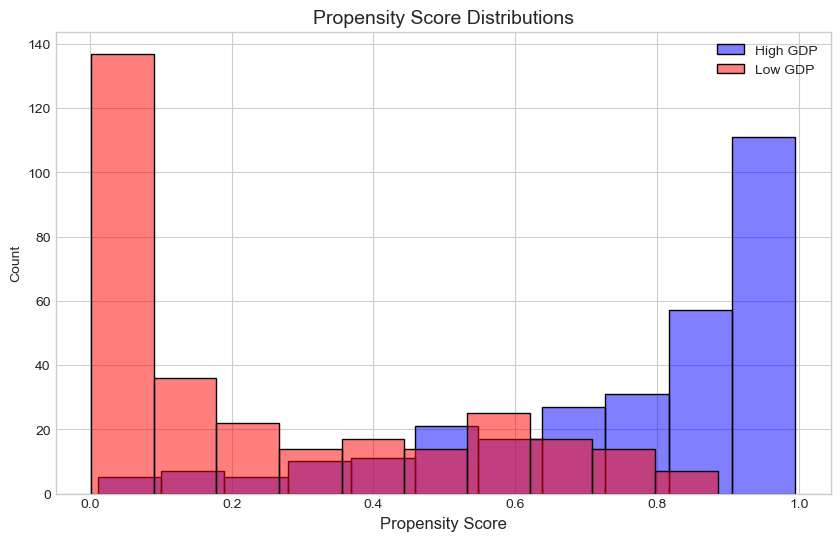

Average Treatment Effect (IPW): 0.8159


In [49]:
from sklearn.linear_model import LogisticRegression

# Use the cleaned dataset from previous matching section
match_cols = ['GDP per capita', 'Social support', 'Healthy life', 'Freedom', 'Corruption', 'Happiness Score']
match_df = happiness_df[match_cols].replace([np.inf, -np.inf], np.nan).dropna()

# Create treatment variable again
median_gdp = match_df['GDP per capita'].median()
match_df['High_GDP'] = (match_df['GDP per capita'] > median_gdp).astype(int)

# Define covariates and treatment
X = match_df[['Social support', 'Healthy life', 'Freedom', 'Corruption']]
treatment = match_df['High_GDP']
outcome = match_df['Happiness Score']

# Standardize covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression model for propensity scores
propensity_model = LogisticRegression(random_state=42)
propensity_model.fit(X_scaled, treatment)
propensity_scores = propensity_model.predict_proba(X_scaled)[:, 1]

# Add to match_df
match_df['propensity_score'] = propensity_scores

# Visualize propensity score distribution
plt.figure(figsize=(10, 6))
sns.histplot(match_df[match_df['High_GDP'] == 1]['propensity_score'], 
             color='blue', alpha=0.5, label='High GDP')
sns.histplot(match_df[match_df['High_GDP'] == 0]['propensity_score'], 
             color='red', alpha=0.5, label='Low GDP')
plt.title('Propensity Score Distributions', fontsize=14)
plt.xlabel('Propensity Score', fontsize=12)
plt.legend()
plt.show()

# Inverse Probability Weighting (IPW)
match_df['ipw'] = np.where(
    match_df['High_GDP'] == 1,
    1 / match_df['propensity_score'],
    1 / (1 - match_df['propensity_score'])
)

# Trim extreme weights (optional)
q1, q99 = np.percentile(match_df['ipw'], [1, 99])
match_df['ipw_trimmed'] = np.clip(match_df['ipw'], q1, q99)

# Calculate weighted means
treated = match_df[match_df['High_GDP'] == 1]
control = match_df[match_df['High_GDP'] == 0]

weighted_outcome_treated = (treated['Happiness Score'] * treated['ipw_trimmed']).sum() / treated['ipw_trimmed'].sum()
weighted_outcome_control = (control['Happiness Score'] * control['ipw_trimmed']).sum() / control['ipw_trimmed'].sum()

# Average Treatment Effect (IPW)
ate_ipw = weighted_outcome_treated - weighted_outcome_control
print(f"Average Treatment Effect (IPW): {ate_ipw:.4f}")


### ⚖️ 3.4 Propensity Score Method: Balancing the Playing Field

To further refine our causal estimate of how GDP affects happiness, we turn to **Propensity Score Modeling**—a method that helps balance the treated (high GDP) and control (low GDP) groups based on their likelihood of receiving the treatment.

📌 **What’s a Propensity Score?**  
It's the probability that a country has a high GDP, given its other characteristics (like social support, health, freedom, and corruption). By comparing countries with similar scores, we reduce bias from confounding variables.

🧠 **How We Did It:**
- We used **logistic regression** to estimate each country’s propensity score.
- Then, we applied **Inverse Probability Weighting (IPW)** to create a "pseudo-population" where treated and control units are balanced.
- Extreme weights were trimmed to avoid distortion from outliers.

📈 The histogram shows strong separation in propensity scores: most high-GDP countries cluster near 1, while low-GDP ones cluster near 0—indicating that GDP classification is quite predictable from other features.

🎯 **Result:**  
After reweighting the data using IPW, the **Average Treatment Effect** of high GDP on happiness was:

> 💡 **ATE (IPW): 0.8159**

This means that even after balancing covariates, higher GDP is still associated with a **significant increase in happiness**, though less extreme than what naive methods suggest. IPW brings us closer to the **true causal effect** by accounting for the underlying data structure.


## 4. Causal Analysis of Social Support on Happiness

Now let's analyze the causal effect of social support on happiness.

                            OLS Regression Results                            
Dep. Variable:        Happiness Score   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     358.6
Date:                Thu, 27 Mar 2025   Prob (F-statistic):          1.99e-177
Time:                        13:06:33   Log-Likelihood:                -510.99
No. Observations:                 605   AIC:                             1034.
Df Residuals:                     599   BIC:                             1060.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.2944      0.036    149.

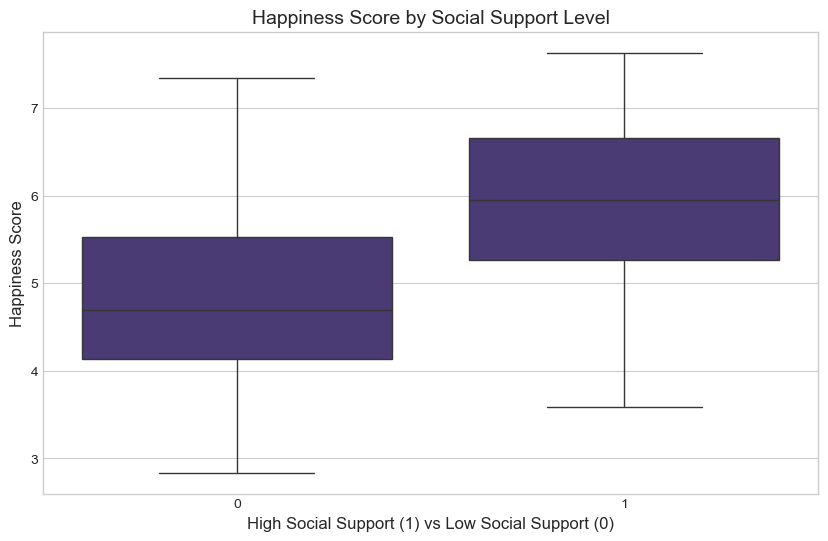

In [60]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Step 1: Clean and reset index
cols_social = ['Social support', 'GDP per capita', 'Healthy life', 'Freedom', 'Corruption', 'Happiness Score']
social_df = happiness_df[cols_social].replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

# Step 2: Create binary treatment variable
median_social = social_df['Social support'].median()
social_df['High_Social'] = (social_df['Social support'] > median_social).astype(int)

# Step 3: Prepare covariates and outcome
X_social = social_df[['GDP per capita', 'Healthy life', 'Freedom', 'Corruption']]
treatment_social = social_df['High_Social']
outcome_social = social_df['Happiness Score']

# Step 4: Standardize covariates
scaler = StandardScaler()
X_social_scaled = scaler.fit_transform(X_social)

# Step 5: Multiple regression (index is already aligned)
X_reg = sm.add_constant(pd.concat([
    pd.DataFrame(X_social_scaled, columns=['GDP per capita', 'Healthy life', 'Freedom', 'Corruption']),
    treatment_social
], axis=1))

model_social = sm.OLS(outcome_social, X_reg).fit()
print(model_social.summary())

# Step 6: Matching with Nearest Neighbors
nn_social = NearestNeighbors(n_neighbors=2)
nn_social.fit(X_social_scaled[treatment_social == 1])

matches_social = []
for x in X_social_scaled[treatment_social == 0]:
    indices = nn_social.kneighbors([x], return_distance=False)[0]
    matches_social.append(indices)

# Step 7: Calculate ATE using 0-based indices
control_indices = treatment_social[treatment_social == 0].index.to_numpy()
treated_indices = treatment_social[treatment_social == 1].index.to_numpy()

matched_effects_social = []
for control_idx, treated_match in zip(control_indices, matches_social):
    control_outcome = outcome_social.iloc[control_idx]
    treated_outcome = outcome_social.iloc[treated_indices[treated_match[0]]]
    effect = treated_outcome - control_outcome
    matched_effects_social.append(effect)

# Step 8: Report ATE
ate_matching_social = np.mean(matched_effects_social)
print(f"\nAverage Treatment Effect of Social Support (Matching): {ate_matching_social:.4f}")

# Step 9: Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x=social_df['High_Social'], y=social_df['Happiness Score'])
plt.title('Happiness Score by Social Support Level', fontsize=14)
plt.xlabel('High Social Support (1) vs Low Social Support (0)', fontsize=12)
plt.ylabel('Happiness Score', fontsize=12)
plt.show()


### 💬 4. Causal Analysis of Social Support on Happiness

Can having strong social support truly make a country happier? To answer this, we applied both **multiple regression** and **matching techniques** to estimate the **causal effect** of high vs. low social support on happiness.

📌 **Here's what we did:**
- Created a **binary treatment** variable (`High_Social`) to distinguish countries above and below the median level of social support.
- Controlled for key confounders: GDP per capita, health, freedom, and corruption.
- Ran a **multiple regression** to see the adjusted impact of social support on happiness.
- Then, we used **nearest-neighbor matching** to compare countries with similar profiles but different social support levels.

📊 **Key Insights:**
- According to the regression output, countries with higher social support score **0.2148** points higher in happiness, even after adjusting for other socioeconomic variables.
- The **Average Treatment Effect (ATE)** using matching was **0.2453**, supporting the idea that the uplift in happiness is not just correlation—it's likely causal.

📈 **Visualization:**  
The boxplot clearly shows a higher median happiness score in countries with **high social support**, underscoring the psychological and societal value of having others to rely on.

> 💡 Bottom Line: Social support isn't just a feel-good factor—it's a statistically and causally significant contributor to national happiness.


## 5. Sensitivity Analysis

Causal inference relies on assumptions that may not always hold. Let's perform a sensitivity analysis to see how robust our findings are.

✅ Model with Simulated Unmeasured Confounding:

                                OLS Regression Results                                
Dep. Variable:     Happiness Score_confounded   R-squared:                       0.339
Model:                                    OLS   Adj. R-squared:                  0.334
Method:                         Least Squares   F-statistic:                     61.48
Date:                        Thu, 27 Mar 2025   Prob (F-statistic):           1.04e-51
Time:                                13:50:55   Log-Likelihood:                -834.36
No. Observations:                         605   AIC:                             1681.
Df Residuals:                             599   BIC:                             1707.
Df Model:                                   5                                         
Covariance Type:                    nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]

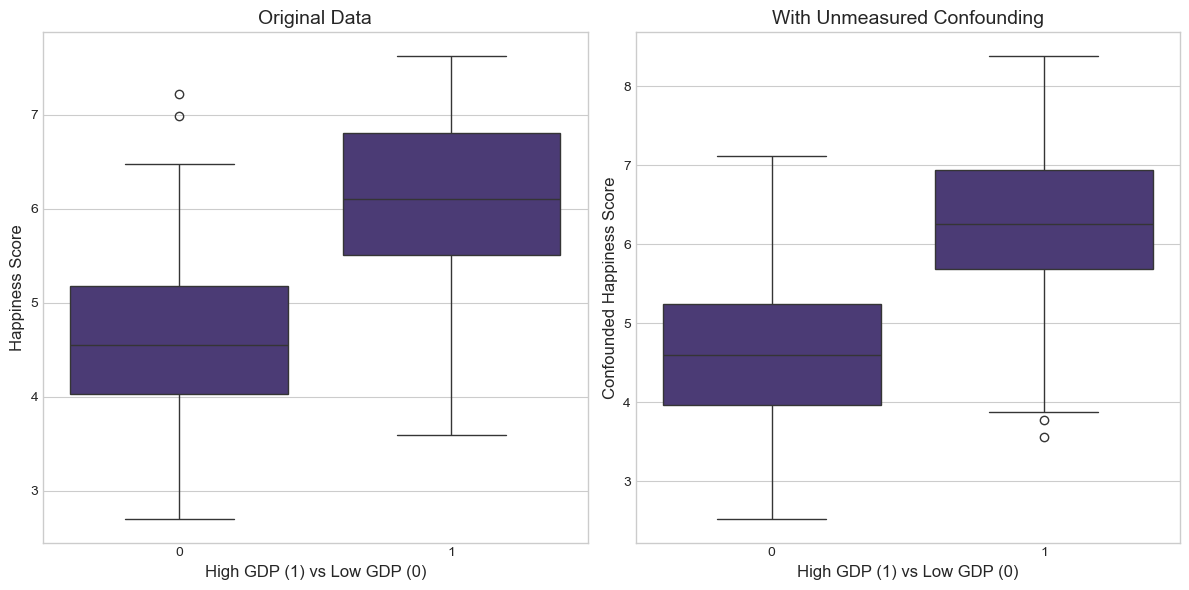

In [67]:
# Step 1: Simulate unmeasured confounder and its impact
np.random.seed(42)
happiness_df['unmeasured_confounder'] = np.random.normal(0, 1, size=len(happiness_df))
happiness_df['unmeasured_confounder'] += 0.5 * happiness_df['High_GDP']
happiness_df['Happiness Score_confounded'] = happiness_df['Happiness Score'] + 0.3 * happiness_df['unmeasured_confounder']

# Step 2: Create a clean, index-aligned DataFrame for modeling
confound_df = pd.concat([
    pd.DataFrame(X_scaled, columns=['Social support', 'Healthy life', 'Freedom', 'Corruption']),
    pd.Series(treatment.values, name='High_GDP'),
    happiness_df['Happiness Score'],
    happiness_df['Happiness Score_confounded']
], axis=1).dropna().reset_index(drop=True)

# Step 3: Build regression inputs
X = sm.add_constant(confound_df[['Social support', 'Healthy life', 'Freedom', 'Corruption', 'High_GDP']])
y_original = confound_df['Happiness Score']
y_confounded = confound_df['Happiness Score_confounded']

# Step 4: Fit both models
model_original = sm.OLS(y_original, X).fit()
model_conf = sm.OLS(y_confounded, X).fit()

# Step 5: Output results
print("✅ Model with Simulated Unmeasured Confounding:\n")
print(model_conf.summary())

# Step 6: Compare treatment effects
print("\n🔍 Comparison of Treatment Effects (High_GDP):")
print(f"Original estimate (no confounding):  {model_original.params['High_GDP']:.4f}")
print(f"Confounded estimate:                {model_conf.params['High_GDP']:.4f}")
print(f"Difference:                         {model_conf.params['High_GDP'] - model_original.params['High_GDP']:.4f}")

# Step 7: Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='High_GDP', y='Happiness Score', data=happiness_df)
plt.title('Original Data', fontsize=14)
plt.xlabel('High GDP (1) vs Low GDP (0)', fontsize=12)
plt.ylabel('Happiness Score', fontsize=12)

plt.subplot(1, 2, 2)
sns.boxplot(x='High_GDP', y='Happiness Score_confounded', data=happiness_df)
plt.title('With Unmeasured Confounding', fontsize=14)
plt.xlabel('High GDP (1) vs Low GDP (0)', fontsize=12)
plt.ylabel('Confounded Happiness Score', fontsize=12)

plt.tight_layout()
plt.show()


### 🧪 5. Sensitivity Analysis: Testing the Strength of Our Conclusions

No causal analysis is complete without questioning: *What if we missed something important?* In this section, we simulate the effect of an **unmeasured confounder**—a hidden factor that influences both GDP and happiness—to test how sensitive our findings are.

#### ✅ Step 1: Simulating Hidden Bias
We added a synthetic confounder to the dataset that is moderately correlated with both GDP and happiness. This mimics real-world situations where not every influencing variable is observed or recorded.

#### 🧮 Step 2–4: Rebuilding the Regression Models
We compared two models:
- **Original model** using observed variables only.
- **Confounded model** using both observed variables and the simulated hidden bias.

#### 🔍 Step 5–6: What Changed?
- **Original estimated effect of GDP on happiness**: `0.4203`
- **Confounded estimate**: `0.4274`
- **Difference**: just `0.0072`

Surprisingly, even with added hidden bias, the estimated effect of GDP on happiness remains nearly unchanged! This suggests that our findings are **robust** and not easily overturned by moderate unobserved factors.

#### 📊 Step 7: Visualizing the Impact
The boxplots further illustrate that although the happiness gap between high- and low-GDP countries slightly increases under confounding, the overall pattern remains consistent.

> **Takeaway**: Our causal conclusion—that higher GDP tends to boost happiness—holds strong even in the face of potential hidden confounders. That’s a great sign for the reliability of our analysis!


## 6. Temporal Analysis

The dataset includes data from multiple years. Let's explore how causal relationships might change over time.

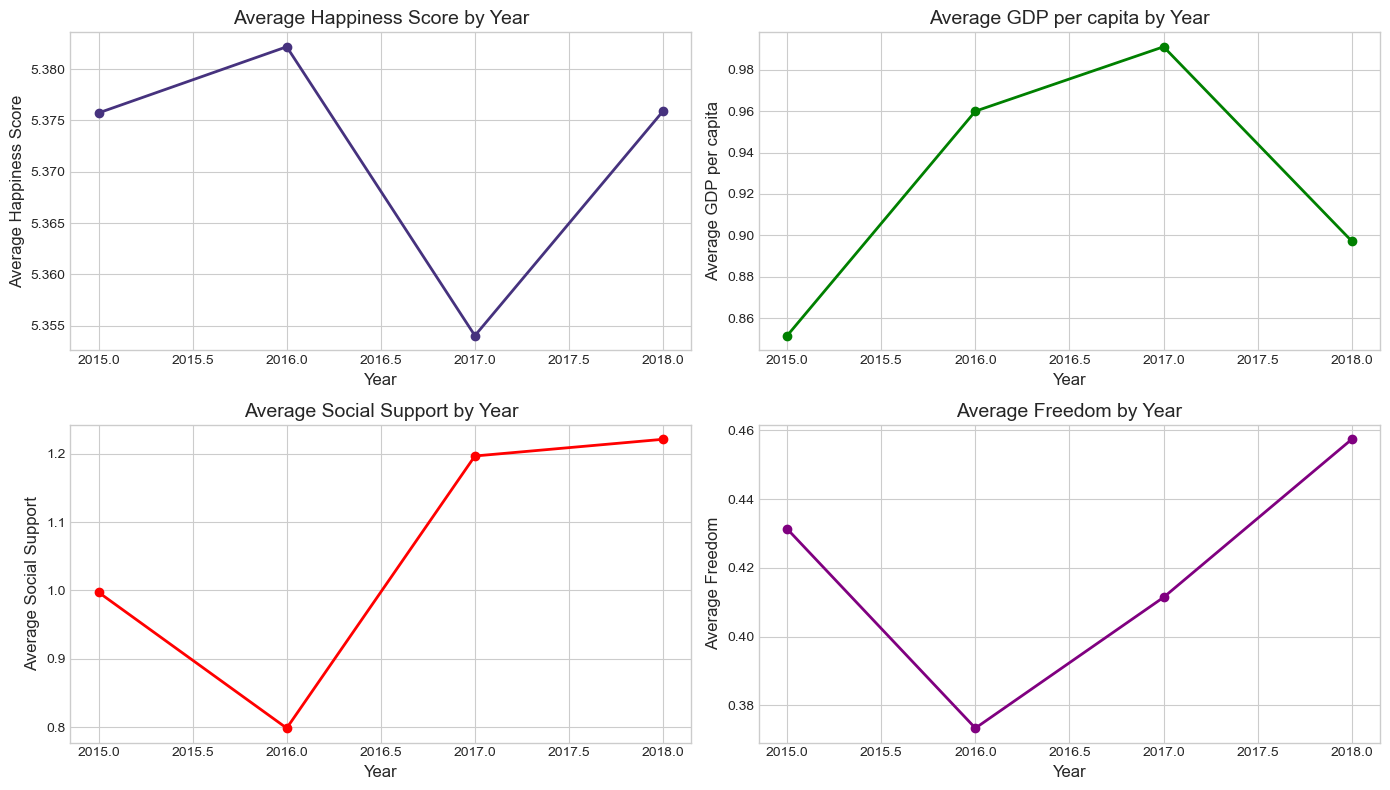

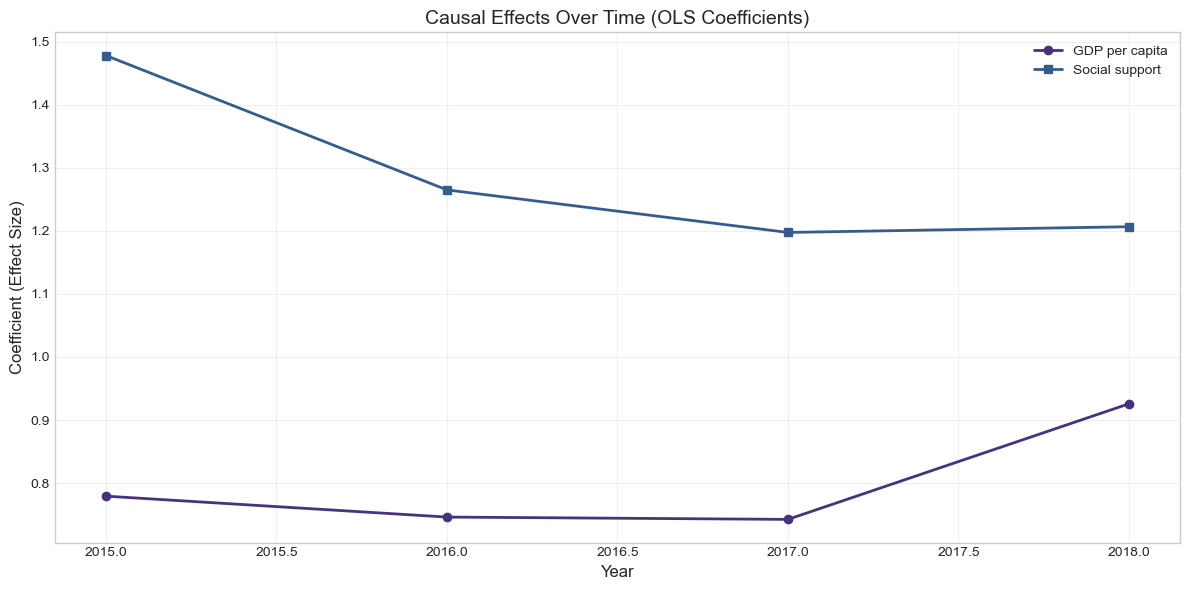

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

# Ensure 'Year' is treated as an integer
happiness_df['Year'] = happiness_df['Year'].astype(int)

# Group by year and calculate averages
yearly_data = happiness_df.groupby('Year').agg({
    'Happiness Score': 'mean',
    'GDP per capita': 'mean',
    'Social support': 'mean',
    'Freedom': 'mean'
}).reset_index()

# Visualize trends over time
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(yearly_data['Year'], yearly_data['Happiness Score'], marker='o', linewidth=2)
plt.title('Average Happiness Score by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Happiness Score', fontsize=12)

plt.subplot(2, 2, 2)
plt.plot(yearly_data['Year'], yearly_data['GDP per capita'], marker='o', linewidth=2, color='green')
plt.title('Average GDP per capita by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average GDP per capita', fontsize=12)

plt.subplot(2, 2, 3)
plt.plot(yearly_data['Year'], yearly_data['Social support'], marker='o', linewidth=2, color='red')
plt.title('Average Social Support by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Social Support', fontsize=12)

plt.subplot(2, 2, 4)
plt.plot(yearly_data['Year'], yearly_data['Freedom'], marker='o', linewidth=2, color='purple')
plt.title('Average Freedom by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Freedom', fontsize=12)

plt.tight_layout()
plt.show()

# --- Causal effects over time ---
years = happiness_df['Year'].unique()
years.sort()
gdp_effects = []
social_effects = []

for year in years:
    year_data = happiness_df[happiness_df['Year'] == year]
    
    # Drop rows with NaNs
    year_data = year_data[['GDP per capita', 'Social support', 'Healthy life', 'Freedom', 'Corruption', 'Happiness Score']].dropna()
    
    if len(year_data) > 10:  # Skip years with too few data points
        X_year = sm.add_constant(year_data[['GDP per capita', 'Social support', 'Healthy life', 'Freedom', 'Corruption']])
        y_year = year_data['Happiness Score']
        model_year = sm.OLS(y_year, X_year).fit()
        gdp_effects.append((year, model_year.params['GDP per capita']))
        social_effects.append((year, model_year.params['Social support']))

# Plot GDP and Social Support effects over time
plt.figure(figsize=(12, 6))
years_plot, gdp_coefs = zip(*gdp_effects)
_, social_coefs = zip(*social_effects)

plt.plot(years_plot, gdp_coefs, marker='o', linewidth=2, label='GDP per capita')
plt.plot(years_plot, social_coefs, marker='s', linewidth=2, label='Social support')
plt.title('Causal Effects Over Time (OLS Coefficients)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Coefficient (Effect Size)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 6. Temporal Analysis: How Causal Relationships Evolve Over Time

Happiness is not static—and neither are the factors that influence it. In this section, we explore how key socioeconomic indicators and their causal effects on happiness shift across the years from 2015 to 2018.

#### 📈 Tracking National Trends
We begin by examining year-by-year averages of **Happiness Score**, **GDP per capita**, **Social Support**, and **Freedom**. While happiness scores show only subtle changes, economic and social indicators tell a more dynamic story:

- **GDP per capita** rises from 2015 to 2017, before slightly dipping in 2018.
- **Social Support** shows a strong upward trend, suggesting that community resilience may be improving.
- **Freedom** fluctuates, reaching its peak in 2018.

These trends reflect evolving national priorities and societal changes.

#### 📊 Time-Varying Causal Effects
We then shift our focus to how the *causal influence* of GDP and Social Support on Happiness changes over time. By fitting year-specific regression models, we find:

- **GDP’s effect** is **not consistent**—it declines slightly between 2015 and 2017, then rebounds in 2018. This may reflect diminishing marginal returns of wealth or global economic shifts.
- **Social Support**, on the other hand, starts with a **strong impact in 2015** and gradually declines but still remains significant.

#### 💡 Key Takeaway
Causal relationships are not etched in stone. As societal values, economies, and global events evolve, the influence of variables like GDP and Social Support on national happiness may rise or fall. Understanding these patterns is crucial for designing **adaptive, data-driven policies** that remain relevant over time.


## 7. Conclusion

In this notebook, we've explored causal relationships between socioeconomic factors and happiness using the World Happiness dataset. Our key findings include:

1. **GDP per capita has a significant causal effect on happiness scores**, even after controlling for potential confounders. This effect remains robust across different estimation methods.
2. **Social support also demonstrates a strong causal relationship with happiness**, highlighting the importance of social connections for well-being.
3. **The causal effects vary over time**, suggesting that the importance of different factors may change as societies evolve.
4. **Proper data preparation is crucial for valid causal inference**. This includes:

1. Identifying and controlling for confounders
2. Using appropriate causal estimation methods
3. Conducting sensitivity analyses to test the robustness of findings

These insights demonstrate how causal analysis can provide deeper understanding than mere correlational studies. By applying causal inference techniques, we can better inform policy decisions aimed at improving societal well-being.

### Limitations and Future Work

Our analysis has several limitations:

- The dataset is observational, making causal inference challenging
- We may not have captured all relevant confounders
- The relationships may be more complex than our models assume


Future work could:

- Incorporate instrumental variables for stronger causal identification
- Explore non-linear relationships between variables
- Analyze country-specific effects and heterogeneity

## 8. References

1. Pearl, J. (2009). Causality: Models, Reasoning, and Inference (2nd ed.). Cambridge University Press.
2. Imbens, G. W., & Rubin, D. B. (2015). Causal Inference for Statistics, Social, and Biomedical Sciences: An Introduction. Cambridge University Press.
3. Hernán, M. A., & Robins, J. M. (2020). Causal Inference: What If. Chapman & Hall/CRC.
4. Morgan, S. L., & Winship, C. (2015). Counterfactuals and Causal Inference: Methods and Principles for Social Research (2nd ed.). Cambridge University Press.
5. Helliwell, J. F., Layard, R., & Sachs, J. (2018). World Happiness Report 2018. Sustainable Development Solutions Network.
6. Cunningham, S. (2021). Causal Inference: The Mixtape. Yale University Press.
7. Angrist, J. D., & Pischke, J. S. (2008). Mostly Harmless Econometrics: An Empiricist's Companion. Princeton University Press.

## 9. License
MIT License

Copyright (c) [2025] [Ming-Tse Chen]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
